# Resolucion de una EDO  

# Modelo exponencial

\begin{equation}
 \frac {dy} {dt} = λt \\
  \end{equation}
 con la condición incial: $y(0) = y_0$

 En este caso, $λ=5$ , $ y_0 = 1$ y $t ∈ [0,1]$

 Luego, tendríamos la siguiente EDO:

 \begin{equation}
 \frac {dy} {dt} = 5t, \\
 \end{equation}
con la condicion incial  $y(0) = 1$ y  $t ∈ [0,1]$ .

Donde su solución exacta es:
\begin{equation}
 \ y= λ \frac {t^2} {2} + y_0,    \
 \ t∈[0,1] \\
 \end{equation}

In [ ]:
# Importar librerias
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.autograd as grad
import matplotlib.pyplot as plt
import time

In [ ]:
# Datos
y0 = 1.
t0 = 0.
tf = 1.
Nf = 1000 # puntos para evaluar el residuo
print_freq = 2000 # imprimir cada epoca

In [ ]:
# Solucion exacta

def ex(t):
  return 5*(t**2)/2 + y0

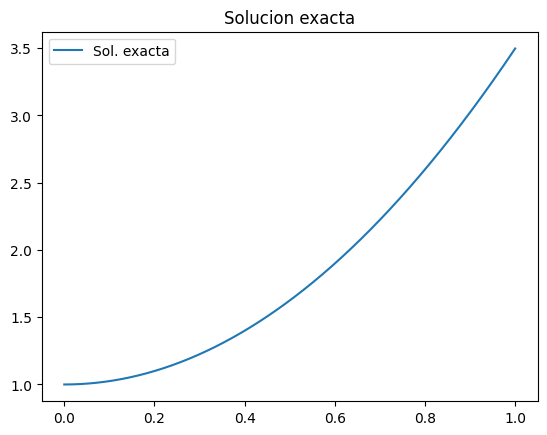

In [ ]:
t0, tf = 0, 1
n = 3000
h = (tf-t0)/n

te = torch.arange(t0,tf,h)
te
ye = ex(te)
plt.figure()
plt.plot(te,ye,label="Sol. exacta")
plt.legend()
plt.title("Solucion exacta")
plt.show()

## 1. Definición de la red neuronal

In [ ]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
class PINN(nn.Module):     # definir la clase (al heredar de nn.Module clase PINN
                           # tiene acceso a muchas utilidades y métodos proporcionados por PyTorch
                           # para el entrenamiento y la evaluación de modelos

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador
                           # llamamos al inicializador de la clase base nn.Module mediante super()
                           # Esto asegura que todas las funcionalidades de nn.Module se inicialicen correctamente
        super(PINN, self).__init__()

        # Definir las capas de la red neuronal (aqui 3 capas lineales: nn.Linear)
        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Una capa lineal significa que salida = Entradas×Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        #self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Entrada con hidden_size características, salida con 1 característica
        self.fc3 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos (I): Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # Inicialización de pesos (II): Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica o la función logística (sigmoid).
        # Ayuda a mantener una varianza constante a través de las capas
        ## Sale mejor en este ejemplo que sin dicha inicializacion
        nn.init.xavier_normal_(self.fc1.weight)
        #nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

        # Inicialización de pesos (III): He Initialization: Similar a la inicialización de Xavier,
        # pero ajustada para su uso con funciones de activación ReLU (Rectified Linear Unit).
        #nn.init.kaiming_normal_(model.fc1.weight)
        #nn.init.kaiming_normal_(model.fc2.weight)
        #nn.init.kaiming_normal_(model.fc3.weight)

        # Inicialización de pesos (IV):  LeCun Initialization:
        # Inicialización propuesta por LeCun para funciones de activación como la tangente hiperbólica
        # nn.init.normal_(layer.weight, mean=0, std=np.sqrt(1 / layer.weight.shape[0]))
        # init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1 / self.fc1.weight.shape[0]))
        # init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1 / self.fc2.weight.shape[0]))
        # init.normal_(self.fc3.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))


    def forward(self, x):
       # Define la operación hacia adelante de la red neuronal, i.e cómo se realiza la operación hacia adelante en la red neuronal.
       # Se aplican funciones de activación tangente hiperbólica (torch.tanh) después de cada capa lineal
       # En este caso, el método forward toma la entrada x y la pasa a través de las capas fc1, fc2 y fc3
       # utilizando la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas.
       # La última capa (fc3) no tiene una función de activación
       x = torch.tanh(self.fc1(x))
       #x = torch.tanh(self.fc2(x))
       x = self.fc3(x)             # No aplicamos función de activación en la última capa fc3

       # Aplicacion a la sigmoide
       #x = torch.sigmoid(self.fc1(x))
       #x = torch.sigmoid(self.fc2(x))
       #x = self.fc3(x)

       return x

## 2. Generar los training data

In [ ]:
print(te.shape)
print(ye.shape)

t = te[::1]
y = ye[::1]
t = torch.Tensor(t).view(-1,1)
y = torch.Tensor(y).view(-1,1)
t.shape

torch.Size([3000])
torch.Size([3000])


torch.Size([3000, 1])

In [ ]:
# Vamos a tomar 26 datos para el entrenamiento

#t_data = t[::119]
#y_data = y[::119]

# Tomamos 11, peor que 26
#t_data = t[::116]
#y_data = y[::166]

# Tomamos 40, no mucha mejora mas parece que hay sobreentrenamiento
#t_data = t[::75]
#y_data = y[::75]

# Tomamos 1, el dato incial solamente, este me da y = 0
t_data = t[::3000]
y_data = y[::3000]

# Tomamos 2, el dato incial + uno enmedio, con este si aprende
#t_data = t[::1500]
#y_data = y[::1500]


t_data.shape, y_data.shape
t_data
y_data

tensor([[1.]])

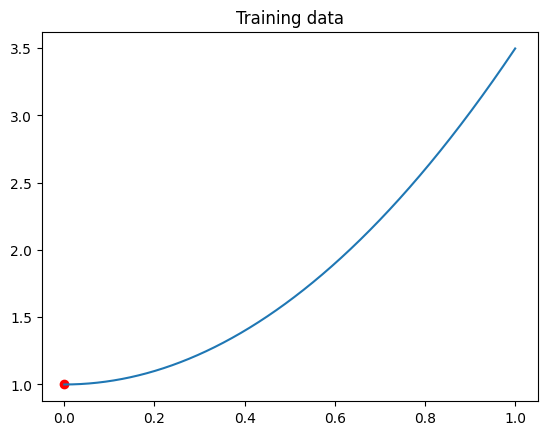

In [ ]:
plt.figure()
plt.plot(t,y)
plt.scatter(t_data,y_data, c="red")
plt.title("Training data")
plt.show()

## 2. PINN

In [ ]:
# Función para calcular la derivada
def compute_derivative(model, x):
    x.requires_grad_(True)         # Activar el flag requires_grad para que se realice el seguimiento de gradientes
    y_pred = model(x)              # Obtener las predicciones del modelo para las entradas
    dy_dx = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return dy_dx, y_pred

# Función para calcular la condición inicial
def initial_condition(model, x_initial):
    return model(x_initial)

In [ ]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, dy_dx_pred, pde_target, yh, y_data):
        loss_pde = self.mse_loss(dy_dx_pred, pde_target)
        loss_initial_condition = self.mse_loss(yh, y_data)
        total_loss = (6e-2)*loss_pde + loss_initial_condition
        return total_loss

In [ ]:
def train(model, optimizer, loss_fn, t_data, t_p, num_epoch):
  loss_history = []
  learning_rates= []

  for epoch in range(num_epoch):
    model.train()
    yh = model(t_data) # datos de entrenamiento, incluyen a la codicion incial
    #yhp = model(t_p) # para la evaluacion de la EDO
    dx, yhp = compute_derivative(model, t_p) # calcula la derivada del modelo con respecto a t_p
    pde_target = 5*t_p # definicion de la EDO
    loss = loss_fn(dx, pde_target, yh, y_data)

    # Optimización
    optimizer.zero_grad()  # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()        # Se realiza la retropropagación backward
    optimizer.step()       # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)

    loss_history.append(loss.item())    # almacentar el error


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)             # almacentar el learning rate

    # Imprimir el progreso
    if (epoch + 1) % print_freq == 0:
      print(f'Epoch [{epoch+1}/{num_epoch}], Total Loss: {loss.item()}')

  return loss_history, learning_rates  # Devolver la lista de pérdida al final del entrenamiento y el lerning rate

In [ ]:
#t_p= torch.linspace(0,1,50).view(-1,1).requires_grad_(True)

In [ ]:
# Crear una instancia del modelo y del optimizador
# model = PINN(input_size, hidden_size, output_size)
input_size = 1
hidden_size = 5
#hidden_size = 32 # voy a aumentar a ver si con esto lo puedo solucionar
#hidden_size = 50
#hidden_size = 10
output_size = 1
#learnig_rate = 0.001
learnig_rate = 0.01
model = PINN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)

loss_fn = PINNLoss()      # Definicion de la funcion de pérdida

# Generar datos de entrenamiento
#x_internal_train = torch.rand((100, 1), requires_grad=True)
#x_initial_train = torch.tensor([[t0]], requires_grad=True)

t_p = torch.linspace(0,1,10).view(-1,1).requires_grad_(True)
#t_p = torch.linspace(0,1,50).view(-1,1).requires_grad_(True) # 50 puntos equidistanciados
#t_p = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)
#t_p = torch.linspace(0,1,1000).view(-1,1).requires_grad_(True)

#num_epoch = 42000
#num_epoch = 34000
#num_epoch = 20000
num_epoch = 10000
#num_epoch = 58000
#num_epoch = 68000
# Registrar el tiempo de inicio
start_time = time.time()

# Entrenar el modelo utilizando la función de entrenamiento
loss_history, learning_rates = train(model, optimizer, loss_fn, t_data, t_p, num_epoch)

# Registrar el tiempo de finalización
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')




Epoch [2000/10000], Total Loss: 0.0017209614161401987
Epoch [4000/10000], Total Loss: 0.0008140674326568842
Epoch [6000/10000], Total Loss: 9.584536746842787e-05
Epoch [8000/10000], Total Loss: 4.3944866774836555e-05
Epoch [10000/10000], Total Loss: 3.747070149984211e-05
 
Tiempo de ejecución: 31.181790351867676 segundos


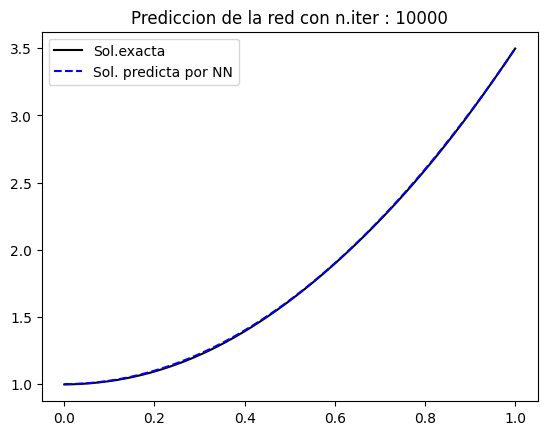

In [ ]:
with torch.no_grad():
  ypred = model(t)

plt.figure()
plt.plot(t,ypred.detach(), c="black", label="Sol.exacta")
plt.plot(t,y,c="blue", linestyle="--", label="Sol. predicta por NN")
plt.legend()
plt.title(f'Prediccion de la red con n.iter : {num_epoch}' )
plt.show()

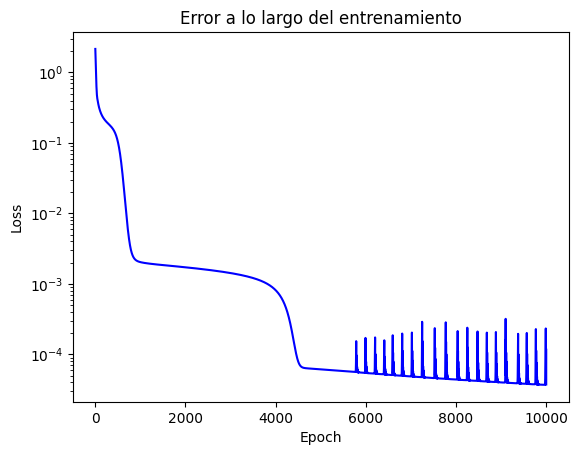

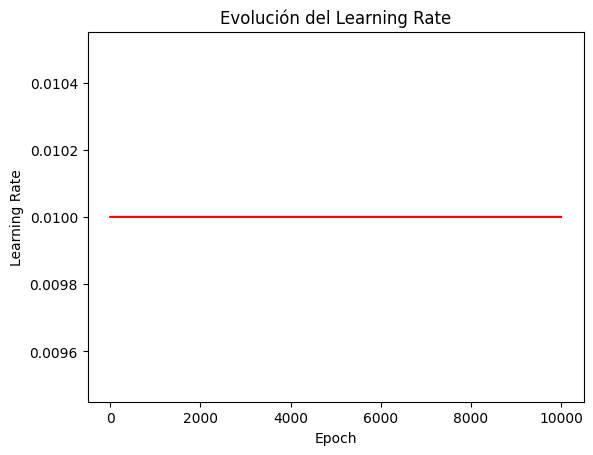

In [ ]:
# Crear una figura con dos subgráficas
plt.figure()
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')
plt.show()

plt.figure()
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')


# Ajustar el diseño y mostrar la gráfica

plt.show()